## RED WINE QUALITY CLASSIFICATION 🍷
Bu notebookta sınıflandırma (classification) yaparak, kırmızı şarapların kalitesini tahmin etmeye çalışacağız. Veri setinde düşük (3-4), orta (5-6) ve yüksek (7-8) olarak farklı kalitelerde şaraplar bulunuyor. Amacımız, veri setindeki özellikleri kullanarak, şarapların kalite puanlarını doğru bir şekilde sınıflandırmak olacaktır.

In [1]:
# gerekli kütüphaneler
import numpy as np  # sayısal işlemler 
import pandas as pd  # veri manipülasyonu 
import seaborn as sns  # görselleştirme
import matplotlib.pyplot as plt  # görselleştirme

# görsel çıktılardaki uyarı mesajları için
import warnings 
warnings.filterwarnings('ignore')

from tabulate import tabulate
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modellerin basarisini degerlendirmek icin
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# models
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
# temizlenmiş verinin wine değişkenine yüklenmesi
wine = pd.read_csv('redwine-clean.csv', index_col=0)
df = wine.copy()

In [3]:
# Modellerin olası bir hata vermesini önlemek için sütun isimlerindeki boşukları _ ile dolduruyoruz.
df.rename(columns = {'fixed acidity': 'fixed_acidity', 'volatile acidity': 'volatile_acidity',
                    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
                    'chlorides': 'chlorides', 'free sulfur dioxide': 'free_sulfur_dioxide',
                    'total sulfur dioxide': 'total_sulfur_dioxide'}, inplace = True)

In [4]:
# xgboost gibi bazı algoritmalar hedef değişkenin değerlerinin 0,1,2... 
# gibi olmasını ister dolayısıyla ona göre düzenleme yapıyoruz
df['quality'] = df['quality'].map({'yuksek': 2, 'orta': 1, 'zayif': 0})

In [5]:
df['quality'].unique()

array([1, 2, 0], dtype=int64)

## Dengesizliğin Giderilmesi

Veri setimizi modellere vermeden önce varyasyonu ve dengesizliği de gidermeliyiz. Eğer bu sorunları çözmez isek modelimiz genelleme yeteneğine sahip olamayabilir. Yani bu verilerde iyi performans gösterirken daha önce hiç görmediği bir veri girdiğimizde çuvallayabilir.

Dengesizliği ve varyasyonu gidermek için belli teknkikler uygulayacağız ve bu teknikleri uygularken belli bir sırayı gözetmemiz gerekiyor, eğer aşağıdaki sıralamanın dışında ilerlersek veri sızıntısı (data leakage) sorunuyla karşılaşabiliriz.

**Data Leakage:** Veri sızıntısı, test verilerinin model eğitiminde dolaylı olarak kullanılmasıdır. Bu, modelin test verilerine aşırı uyum göstermesine ve gerçek performansını abartmasına neden olabilir. Bu durum, genellikle modelin doğru bir şekilde genelleştirilmesini engeller. 

İşlem sıralaması:
1. test-train ayrımı
2. standartlaştırma (sadece bağımsız değişkenler)
3. SMOTE (sadece train verilerine)

In [6]:
# bağımlı ve bağımsız değişkenlerimizi belirliyoruz
y = df['quality']                    # bağımlı değişken
x = df.drop(['quality'], axis=1)     # bağımsız değişkenler

In [7]:
x.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8


In [8]:
y.head(2)

0    1
1    1
Name: quality, dtype: int64

## Train-Test-Split

In [9]:
# verinin train ve test olarak ikiye bölünmesi 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
print('X_train =', X_train.shape)
print('y_train =', y_train.shape)
print('X_test =', X_test.shape)
print('y_test =', y_test.shape)

X_train = (1279, 11)
y_train = (1279,)
X_test = (320, 11)
y_test = (320,)


### Veri Standardizasyonu

Veri standardizasyonu, verilerdeki ölçü birimleri farklılıklarını ortadan kaldırarak, verileri karşılaştırılabilir hale getirme işlemidir. Bu işlemi yapmamızdaki sebep verideki değişkenlerin yüksek varyasyona sahip olmasıdır. Değişkenleri standart hale getirmek bu etkiyi azaltacaktır.

Biz en yaygın standardizasyon şekli olan Z-Standartlaştırmasını kullanacağız.

### $z = \frac{{x - \mu}}{{\sigma}}$

Burada:
- $z$ standartlaştırılmış değeri temsil eder.
- $x$ orijinal değeri temsil eder.
- $\mu$ veri setinin ortalamasıdır.
- $\sigma$ veri setinin standart sapmasıdır.

Bu işlem sonrasında verilerin ortalaması 0 ve standart sapması da 1 değerini alır.

**Verileri standartlaştırmak dağılımın şeklini bozmaz.**

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## SMOTE

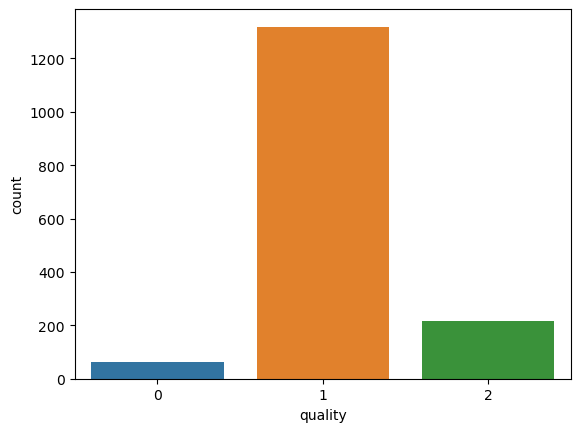

In [12]:
# quality değişkeni üzerindeki dengesizliği gözlemleyelim
sns.countplot(data=df, x='quality')
plt.show()

In [13]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

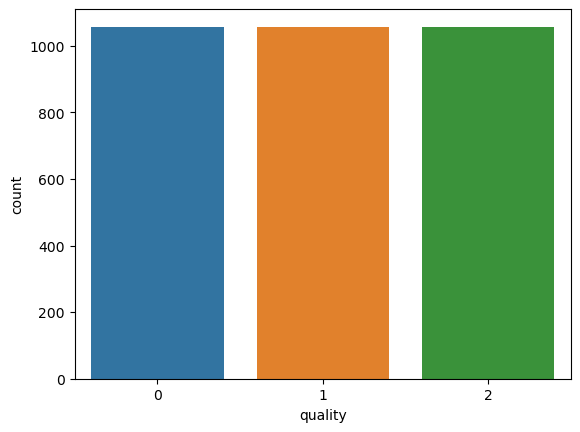

In [14]:
sns.countplot(x=y_train)
plt.show()

# 📊 MODELS

In [15]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Classifier', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LightGBM', lgb.LGBMClassifier()),
    ('CatBoost', cb.CatBoostClassifier(verbose=0)),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

results = []
confusion_matrices = []
classification_reports = []

for model_name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=10)
    mean_accuracy = cv_results.mean()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    results.append((model_name, mean_accuracy, accuracy))
    confusion_matrices.append((model_name, cm))
    classification_reports.append((model_name, cr))

df_results = pd.DataFrame(results, columns=['Model', 'Cross-Validation Accuracy', 'Test Accuracy'])
df_results.sort_values('Cross-Validation Accuracy', ascending=False, inplace=True)

print(df_results.to_string(index=False))

                    Model  Cross-Validation Accuracy  Test Accuracy
                  XGBoost                   0.955561       0.853125
                 CatBoost                   0.955236       0.853125
                 LightGBM                   0.953667       0.853125
            Random Forest                   0.952390       0.850000
        Gradient Boosting                   0.904792       0.803125
            Decision Tree                   0.887115       0.787500
                      KNN                   0.881114       0.696875
Support Vector Classifier                   0.861564       0.728125
                 AdaBoost                   0.699159       0.525000
      Logistic Regression                   0.679279       0.603125
              Naive Bayes                   0.631036       0.465625


## Confusion Matrices (Karmaşıklık Matrisleri)

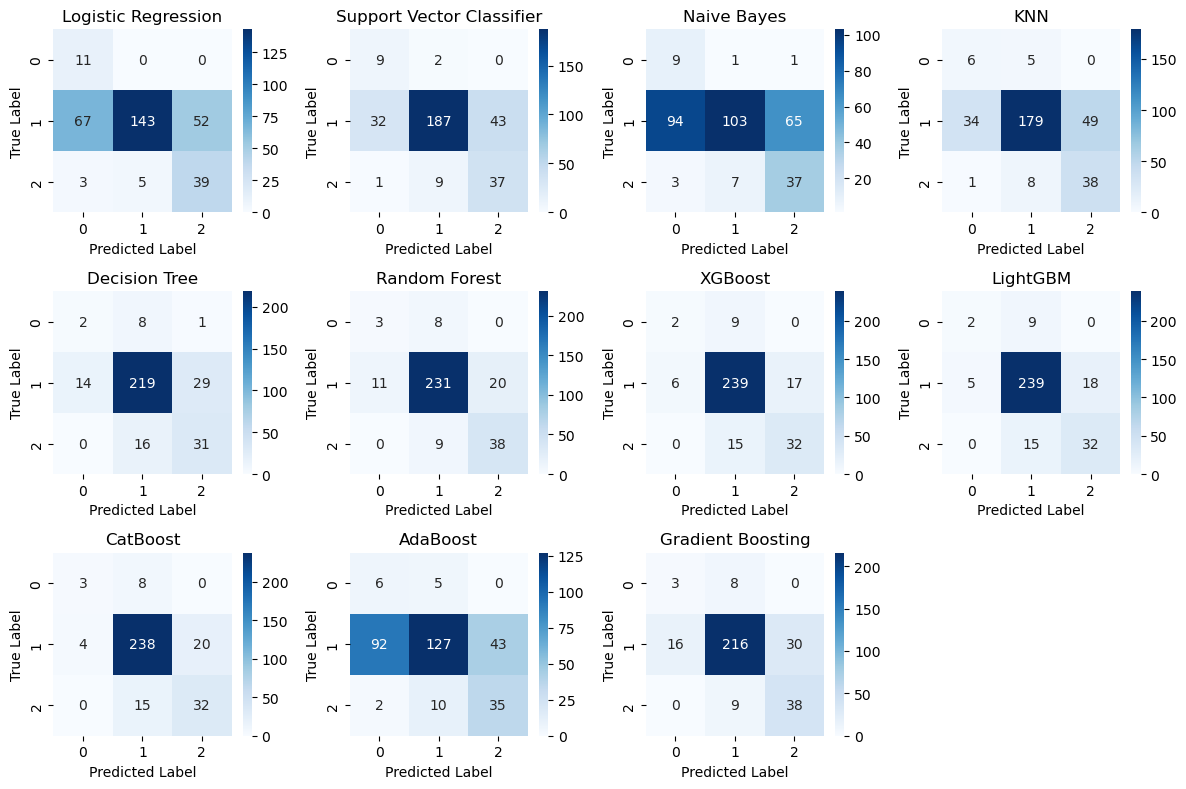

In [16]:
plt.figure(figsize=(12, 8))
for i, (model_name, cm) in enumerate(confusion_matrices, 1):
    plt.subplot(3, 4, i)
    plt.title(model_name)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Classification Reports

In [17]:
for model_name, cr in classification_reports:
    print(f'\033[1m{model_name}:\033[0m')
    print(f'\033[1mClassification Report:\033[0m')
    print(cr)
    print('-'*60)

Logistic Regression:
Classification Report:
              precision    recall  f1-score   support

           0       0.14      1.00      0.24        11
           1       0.97      0.55      0.70       262
           2       0.43      0.83      0.57        47

    accuracy                           0.60       320
   macro avg       0.51      0.79      0.50       320
weighted avg       0.86      0.60      0.66       320

------------------------------------------------------------
Support Vector Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.82      0.34        11
           1       0.94      0.71      0.81       262
           2       0.46      0.79      0.58        47

    accuracy                           0.73       320
   macro avg       0.54      0.77      0.58       320
weighted avg       0.85      0.73      0.76       320

------------------------------------------------------------
Naive Bayes:
Classific

## Random Forest Tuning with Optuna

In [18]:
import optuna

def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    clf = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split, 
                                 min_samples_leaf=min_samples_leaf, 
                                 max_features=max_features, n_jobs=-1)
    
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    accuracy = scores.mean()
    return accuracy

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, show_progress_bar=False)

best_params = study.best_params
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

[I 2023-07-12 23:34:07,983] A new study created in memory with name: no-name-790e7ed5-5e3e-499a-b758-2316d14307ef


In [20]:
print("Best Params:", best_params)
print(f'Test Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')
print(f'Classification Report:\n{cr}')

Best Params: {'n_estimators': 478, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Test Accuracy: 0.85625
Confusion Matrix:
[[  4   7   0]
 [ 12 233  17]
 [  1   9  37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.36      0.29        11
           1       0.94      0.89      0.91       262
           2       0.69      0.79      0.73        47

    accuracy                           0.86       320
   macro avg       0.62      0.68      0.64       320
weighted avg       0.87      0.86      0.86       320

